# Exercise: Semantic segmentation of intergranular fractions from image data

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# for processing image data we use fastai.vision
from fastai.vision.all import * 
# At the latest, we should definitely use the GPU for computing. Therefore, the very first thing we test is,
# if we have a kind CUDA device available
print(torch.cuda.get_device_name(0))
print(torch.__version__)

NVIDIA GeForce RTX 3070
2.3.0+cu121


In [4]:
# Random seed fixieren -> pseudo zufällig 
torch.manual_seed(0) # für pyTorch
random.seed(0)       # für python

Sometimes we get problems with occupied memory on the GPU. In these cases it can help to run the garbage collection. Alternatively, the entire Jupyter server can be restarted, which works more reliably.

In [5]:
import gc
gc.collect()

0

In [7]:
import pathlib
path = Path('./data/64')

# Um höhere Auflösungen zu testen, kann dies hier geändert werden:
# path = Path('./data/intergranular_crack/256')
path.ls()

(#2) [Path('data/64/images'),Path('data/64/mask')]

We now create two paths, one for images and one for masks (labels).

In [8]:
path_images = path/'images'
path_labels = path/'mask'

## Get overview of data set

We check the naming of the files

In [9]:
file_names = get_image_files(path_images)
file_names[:3]

(#3) [Path('data/64/images/0304.png'),Path('data/64/images/0007.png'),Path('data/64/images/0878.png')]

And how the corresponding label files are names

In [10]:
label_names = get_image_files(path_labels)
label_names[:3]

(#3) [Path('data/64/mask/0304.png'),Path('data/64/mask/0007.png'),Path('data/64/mask/0878.png')]

Since image names and label names do not differ, we only need to map folders to each other to get the corresponding mask for an image. 

In [13]:
def label_function(filename):
    return path_labels / filename.name

# Often label functions are also written using lambda expressions. The label function above could be expressed as
# following as a lambda expression:
# get_y_fn = lambda x: path_labels/f'{x.stem}{x.suffix}'

We first test whether the paths match each other.

In [14]:
print( file_names[0] )
print( label_function(file_names[0]) )

data/64/images/0304.png
data/64/mask/0304.png


With the help of this function we can display the corresponding label image:

In [15]:
import matplotlib.pyplot as plt
import numpy

image = load_image(file_names[3])
mask = load_image(label_function(file_names[3]))
mask2 = load_image(label_function(file_names[5]))

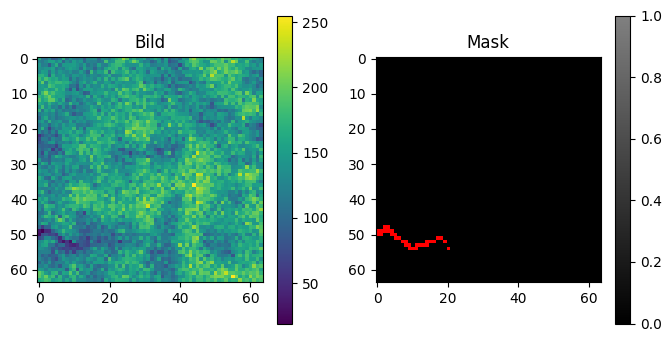

In [16]:
# In this cell, we'll look at how to display labels, in this case images that contain only values 0 and 1. 
# can be displayed in a way that is visually clear. This takes us away from the core of this exercise, but is
# but very useful

# We will create a custom ColorMap, which will result in our masks being displayed in a colorful way.
import matplotlib as mp
cpts = [0.0, 254.0/255.0, 1.0]
colors = [(cpts[0], (0, 0, 0)), (cpts[1], (.5, .5, .5)), (cpts[2], (1, 0, 0))]
cmap_name = 'my_list'
colormap = mp.colors.LinearSegmentedColormap.from_list(cmap_name, colors)

# The following example shows how to use matplotlib.pyplot to create graphs with 
# multiple parts. For this task it is not necessarily
# necessary to inspect data after loading, but is definitely # advisable.
# advisable
figure = plt.figure( figsize=(8,4))
axis = figure.add_subplot(1, 2, 1)
axis.set_title('Bild')
plt.imshow(image)
plt.colorbar()
axis = figure.add_subplot(1, 2, 2)
axis.set_title('Mask')
display_mask = numpy.asarray(mask) 
plt.imshow(display_mask, cmap=colormap)
plt.colorbar()

This way we check what is stored in the label image and if it was loaded correctly.

To be able to map the pixel values to a class, we still need to specify the appropriate mapping:

In [17]:
print( mask.getextrema() )
codes = np.array(['background','crack'])
codes

(0, 1)


array(['background', 'crack'], dtype='<U10')

## Load Dataset

We create a SegmentationDataLoaders that loads the appropriate output (labels) for each image using a label_function.

In [18]:
datablocks = DataBlock(blocks=[ImageBlock, MaskBlock(codes)],
                       get_items = get_image_files,
                       get_y = label_function,
                       splitter=RandomSplitter(seed=42))

data_loader = datablocks.dataloaders(path_images, bs=4, num_workers=0 )

Analogous to our classification example, we output a minibatch for control.

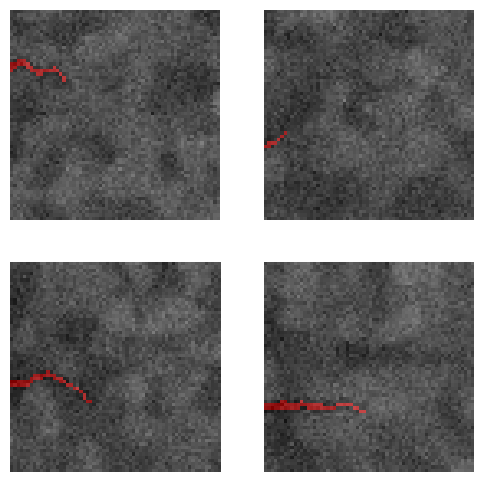

In [19]:
data_loader.show_batch( max_n=4, vmin=0, vmax=1, cmap=colormap )

## Metrics

We still need to adapt the used metric to our segmentation problem. For a better understanding, let's first look at the original version of Accuracy (original_accuracy) because the code is not easy to understand.

In [ ]:
from fastai.torch_core import TensorBase

# Input is:
# Predictions in hot-1-encoding, format batchsize x n_classes x x_size x y_size, z.B. 4x2x128x128
# Target                         format batchsize x x_size x y_size,             z.B. 4x128x128
def original_accuracy(predictions, target):
    # Zunächst machen wir das hot-1-encoding von Predictions rückgängig, indem wir die Indices der höchsten Werte bestimmen
    pred_hot1_decoded = predictions.argmax(dim=1)
    # Then we store in a vector in each case "True" if Prediction and Target agree, "False" if not.
    # Here it is to be noted that the operator == stands for a comparison. Applied to a vector it returns
    # a vector back over "True" where the two values match. 
    # The operator = stands for an assignment and should not be confused with the comparison (==).
    correct_predictions = ( TensorBase(pred_hot1_decoded) == TensorBase(target) )
    # We convert this vector to float, this way "True" becomes 1.0, "False" becomes 0.0
    correct_predictions = correct_predictions.float()
    # The mean value then indicates exactly how high the proportion of correct predictions is
    return correct_predictions.mean()

def accuracy_crack(predictions, target):   
    # implement the accuracy crack which is computing accuracy only for the crack class

In [ ]:
metrics = [accuracy_crack, original_accuracy]

## Network Model

For segmentation we use `U-NET`, which is practically already available in the form of `unet_learner`.

In [ ]:
import torchvision.models as torchModels

learner = unet_learner(data_loader, torchModels.vgg16, metrics = metrics)
# implement your own U-Net model here

learner.loss_func

In [ ]:
# Empties available GPU memory via garbage collection
gc.collect()

In [ ]:
learner.save("unet_initial")

In [ ]:
learner.lr_find()

In [ ]:
gewaehlteLernrate = 0.001

In [ ]:
learner.load("unet_initial")
learner.fit_one_cycle(5, slice(gewaehlteLernrate), cbs=[ShowGraphCallback()])

In [ ]:
preds = learner.get_preds() 

In [ ]:
learner.show_results( figsize=(12,10), vmin=0, vmax=1, cmap=colormap )